In [2]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,Conv1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from matplotlib.pyplot import imshow
from PIL import Image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import glob
import matplotlib.image as mpimg
import random
%matplotlib inline

In [3]:
BASE_DIR = "../input/covid-pneumonia-normal-chest-xray-images/"
os.listdir(BASE_DIR)

['PNEUMONIA', 'NORMAL', 'COVID']

In [4]:
img  = Image.open(BASE_DIR + "COVID/COVID.png")
arr = np.array(img)
arr.shape

(256, 256, 3)

In [5]:
batch_size = 32
image_size = (256,256)
train_ds = image_dataset_from_directory(
    BASE_DIR,
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 42,
    validation_split = 0.2,
    subset = "training",
)
val_ds = image_dataset_from_directory(
    BASE_DIR,
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 42,
    validation_split = 0.2,
    subset = "validation",
)

Found 5228 files belonging to 3 classes.
Using 4183 files for training.
Found 5228 files belonging to 3 classes.
Using 1045 files for validation.


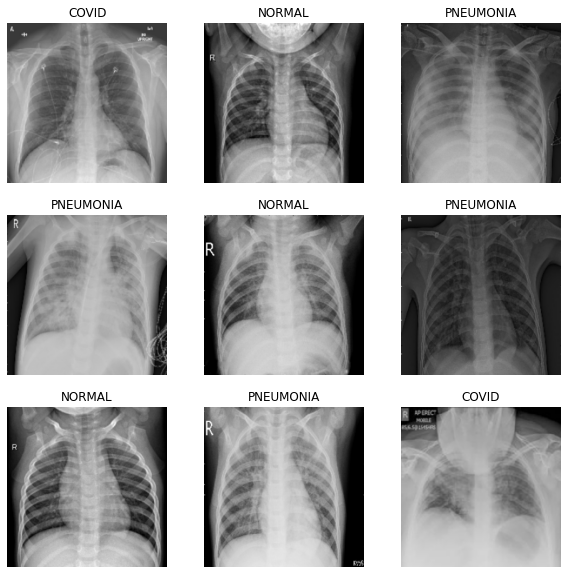

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
normalize_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [9]:
train_ds = train_ds.map(lambda x,y: (normalize_layer(x),y))
val_ds = val_ds.map(lambda x,y: (normalize_layer(x), y))

In [10]:
def inception_block(x,filters,strides = (1,1,1)):
    f1,f2,f3,f4,f5,f6 = filters
    s1,s2,s3 = strides
    x_one = Conv2D(filters = f1,kernel_size=(1,1),strides=s1,activation=relu)(x)
    x_two = Conv2D(filters = f2, kernel_size = (1,1),strides=s2,activation=relu)(x)
    x_two = Conv2D(filters = f3, kernel_size = (3,3),strides=s2,padding="same",activation=relu)(x_two)
    x_three = Conv2D(filters = f4, kernel_size = (1,1),strides=s3,activation=relu)(x)
    x_three = Conv2D(filters = f5,kernel_size = (5,5), strides=s3,padding="same",activation=relu)(x_three)
    x_pool = MaxPooling2D(pool_size=(2,2),strides=1,padding="same")(x)
    x_pool = Conv2D(filters = f6, kernel_size = (1,1),strides = 1,activation=relu)(x_pool)
    x_final = tf.keras.layers.concatenate([x_one,x_two,x_three,x_pool],axis=3)
    return x_final


In [26]:
def model(input_shape = (256,256,3)):
    x_input = Input(input_shape)
  
    x = Conv2D(filters = 64, kernel_size=(7,7),strides=2)(x_input)
    x = BatchNormalization(axis=3)(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=2,strides=2)(x)

    x = Conv2D(filters=64,kernel_size = 1)(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation("relu")(x)
    x = Conv2D(filters =192,kernel_size=3,padding="same")(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=2,strides=2)(x)

    x = inception_block(x,(64,96,128,16,32,32))
    x = inception_block(x,(128,128,192,32,96,64))
    x = MaxPooling2D(pool_size=2,strides=2)(x)

    x = inception_block(x,(192,96,208,16,48,64))
    x = inception_block(x,(160,112,224,24,64,64))
    x = inception_block(x,(128,128,256,24,64,64))
    x = inception_block(x,(112,144,288,32,64,64))
    x = inception_block(x,(256,160,320,32,128,128))
    x = MaxPooling2D(pool_size=2,strides=2)(x)

    x = inception_block(x,(256,160,320,32,128,128))
    x = inception_block(x,(384,192,384,48,128,128))

    x = AveragePooling2D(pool_size=7,strides=1)(x)

    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(units=128,activation=relu)(x)
    x_output = Dense(units=3,activation="softmax")(x)
    model = Model(x_input,x_output)
    return model

In [27]:
model = model(input_shape=(256,256,3))
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, 125, 125, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 125, 125, 64) 256         conv2d_171[0][0]                 
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 125, 125, 64) 0           batch_normalization_3[0][0]      
____________________________________________________________________________________________

In [28]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [32]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,log=None):
        if log["accuracy"] >= .998:
            print("Stopping training")
            self.stop_training = True

In [33]:
callbacks = myCallback()

In [34]:
history = model.fit(train_ds,epochs=30,callbacks=[callbacks])

Epoch 1/30
131/131 [==============================] - 12s 95ms/step - loss: 0.4458 - accuracy: 0.8312
Epoch 2/30
131/131 [==============================] - 13s 96ms/step - loss: 0.3168 - accuracy: 0.8905
Epoch 3/30
131/131 [==============================] - 13s 96ms/step - loss: 0.2295 - accuracy: 0.9216
Epoch 4/30
131/131 [==============================] - 13s 96ms/step - loss: 0.1582 - accuracy: 0.9443
Epoch 5/30
131/131 [==============================] - 13s 96ms/step - loss: 0.1584 - accuracy: 0.9467
Epoch 6/30
131/131 [==============================] - 12s 95ms/step - loss: 0.1228 - accuracy: 0.9601
Epoch 7/30
131/131 [==============================] - 13s 96ms/step - loss: 0.1099 - accuracy: 0.9622
Epoch 8/30
131/131 [==============================] - 12s 95ms/step - loss: 0.1074 - accuracy: 0.9656
Epoch 9/30
131/131 [==============================] - 13s 96ms/step - loss: 0.0949 - accuracy: 0.9716
Epoch 10/30
131/131 [==============================] - 13s 96ms/step - loss: 0.077

In [35]:
model.evaluate(val_ds)

33/33 [==============================] - 2s 40ms/step - loss: 0.1395 - accuracy: 0.9694


[0.13952583074569702, 0.9693779945373535]

In [36]:
batch_size = 32
image_size = (256,256)
experiment_ds = image_dataset_from_directory(
    BASE_DIR,
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 42,
    validation_split = 0.2,
    subset = "validation",
)

Found 5228 files belonging to 3 classes.
Using 1045 files for validation.


In [37]:
normalize_exp_ds = experiment_ds.map(lambda x,y : (normalize_layer(x),y))

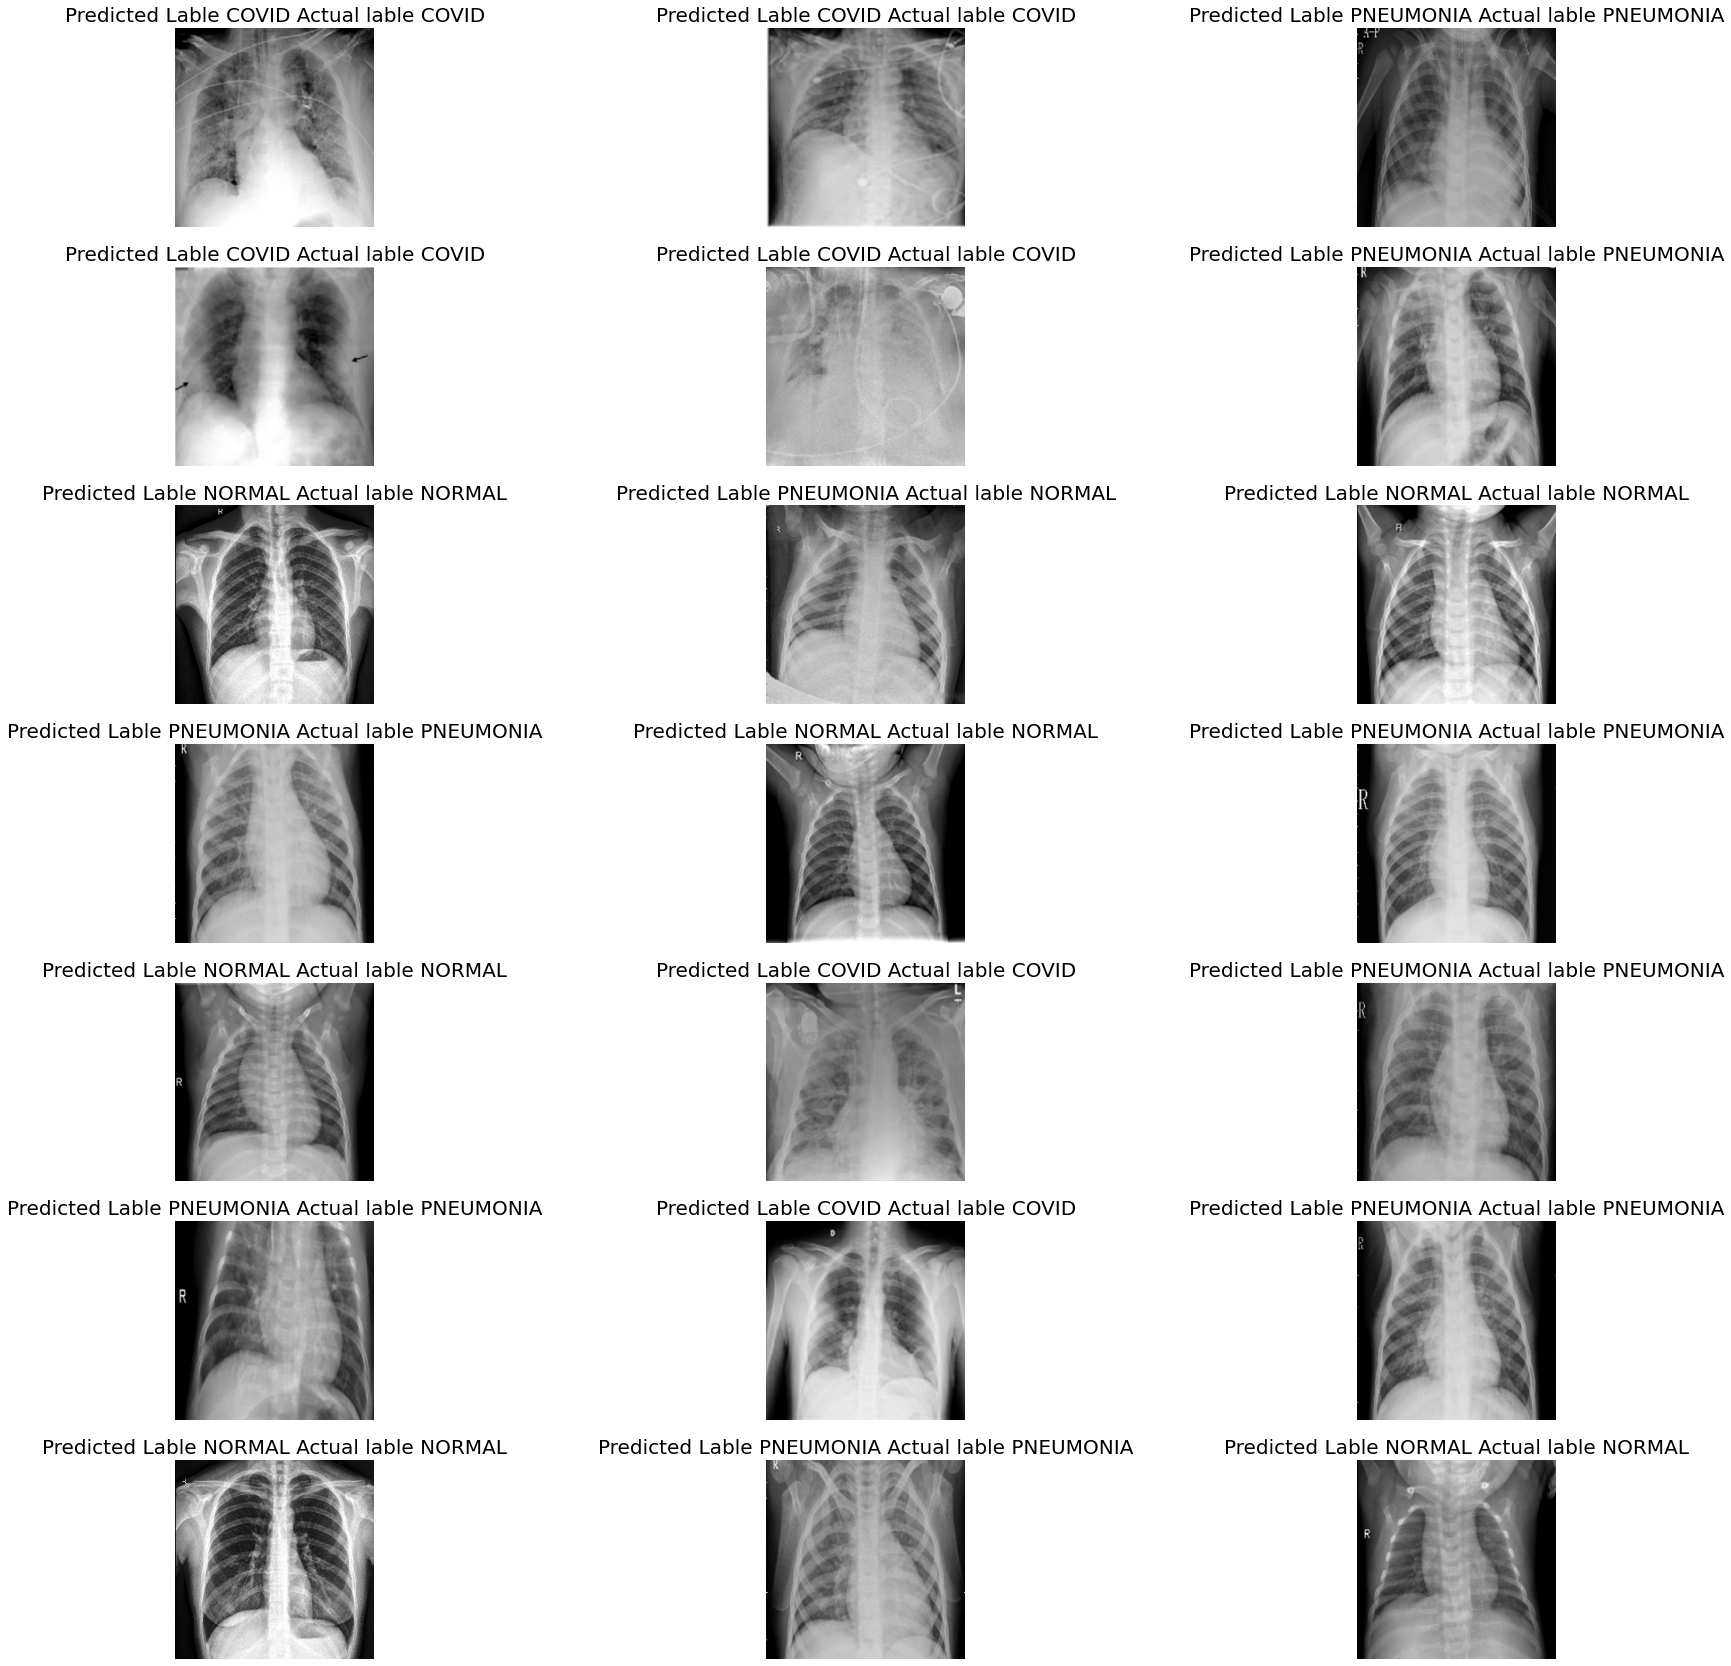

In [42]:
plt.figure(figsize=(30, 30))
for images, labels in experiment_ds.take(5):
    for i in range(21):
        ax = plt.subplot(7, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Predicted Lable "+ experiment_ds.class_names[np.argmax(model.predict((images[i].numpy().reshape((1,256,256,3))) / 255.))] +" Actual lable "+  experiment_ds.class_names[labels[i]],fontsize = 20)
        plt.axis("off")

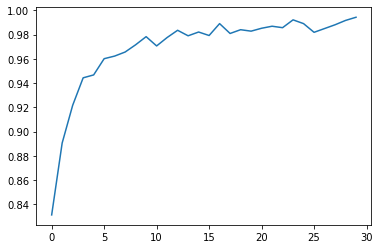

In [43]:
acc = []
acc += history.history["accuracy"]
plt.plot(acc)